### file import & dataset

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

In [1]:
import warnings # Í≤ΩÍ≥† Ï†úÍ±∞
warnings.filterwarnings('ignore')

In [4]:
train_img_dir = "../data/train"
train_df = pd.read_csv("../data/train.csv")

### data Î∂ÑÏÑù

In [5]:
# ========== Blur Score (Laplacian variance) ==========
def calc_blur_score(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

In [6]:
# ========== Noise Score (FFT-based) ==========
def calc_noise_score(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return np.var(magnitude_spectrum)

In [7]:
# ========== Motion Blur Score (Edge Î∞©Ìñ•ÏÑ± std) ==========
def calc_motion_blur_score(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is not None and len(lines) > 0:
        angles = [(theta * 180 / np.pi) for [[_, theta]] in lines]
        return np.std(angles)
    else:
        return 0

In [8]:
# ========== Skew Angle (Hough Transform) ==========
def calc_skew_angle(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is not None:
        angles = [(theta * 180 / np.pi) - 90 for [[_, theta]] in lines]
        return np.median(angles)
    else:
        return 0

In [9]:
# ========== Mask Ratio ==========
def calc_mask_ratio(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    white_ratio = np.sum(binary == 255) / binary.size
    return white_ratio

In [10]:
# ========== Í≤∞Í≥º Ï†ÄÏû• ==========
results = []

for idx, row in train_df.iterrows():
    file_name = row['ID']
    target = row['target']
    img_path = os.path.join(train_img_dir, file_name)
    
    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    blur_score = calc_blur_score(img)
    noise_score = calc_noise_score(img)
    motion_blur_score = calc_motion_blur_score(img)
    skew_angle = calc_skew_angle(img)
    mask_ratio = calc_mask_ratio(img)

    results.append({
        'ID': file_name,
        'target': target,
        'blur_score': blur_score,
        'noise_score': noise_score,
        'motion_blur_score': motion_blur_score,
        'skew_angle': skew_angle,
        'mask_ratio': mask_ratio
    })

# DataFrame ÏÉùÏÑ±
eda_df = pd.DataFrame(results)

# Ï†ÄÏû•
eda_df.to_csv("../data/train_eda_advanced.csv", index=False)

print("‚úÖ EDA Î∂ÑÏÑù ÏôÑÎ£å! Í≤∞Í≥ºÎäî train_eda_advanced.csv ÌååÏùºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

‚úÖ EDA Î∂ÑÏÑù ÏôÑÎ£å! Í≤∞Í≥ºÎäî train_eda_advanced.csv ÌååÏùºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


### Test EDA Î∂ÑÌè¨ÏôÄ ÎπÑÍµê

In [11]:
train_eda_df = pd.read_csv("../data/train_eda_advanced.csv")

In [12]:
# Test Í∏∞Ï§Ä Î∂ÑÌè¨ Î≤îÏúÑ (EDA advanced Í∏∞Ï§Ä : ÏàòÏ†ï Í∞ÄÎä•)
test_blur_thresh = 500
test_noise_thresh = 800
test_skew_thresh = 30
test_mask_thresh = 0.1
test_motion_blur_thresh = 20

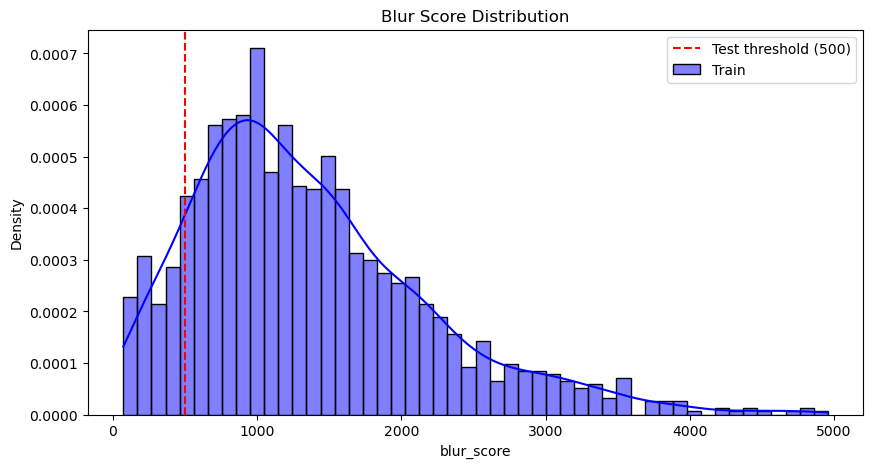

In [14]:
# Blur Score Î∂ÑÌè¨ ÎπÑÍµê

plt.figure(figsize=(10, 5))
sns.histplot(train_eda_df["blur_score"], color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_blur_thresh, color="red", linestyle="--", label=f"Test threshold ({test_blur_thresh})")
plt.title("Blur Score Distribution")
plt.legend()
plt.show()

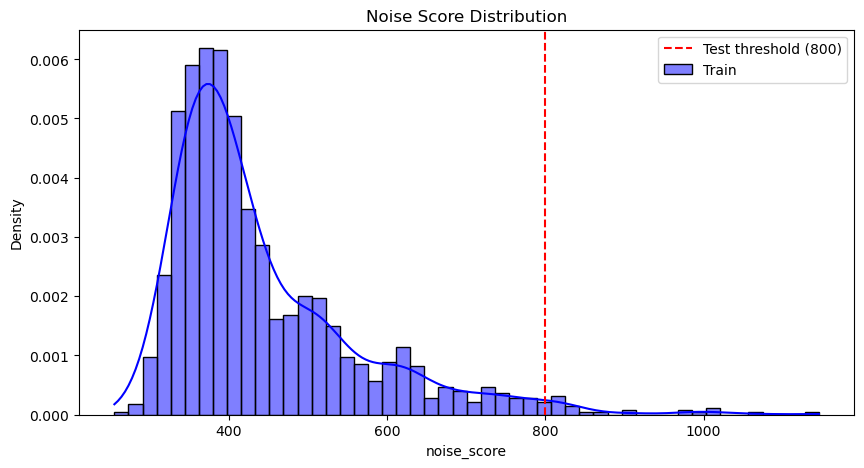

In [15]:
# Noise Score Î∂ÑÌè¨ ÎπÑÍµê

plt.figure(figsize=(10, 5))
sns.histplot(train_eda_df["noise_score"], color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_noise_thresh, color="red", linestyle="--", label=f"Test threshold ({test_noise_thresh})")
plt.title("Noise Score Distribution")
plt.legend()
plt.show()

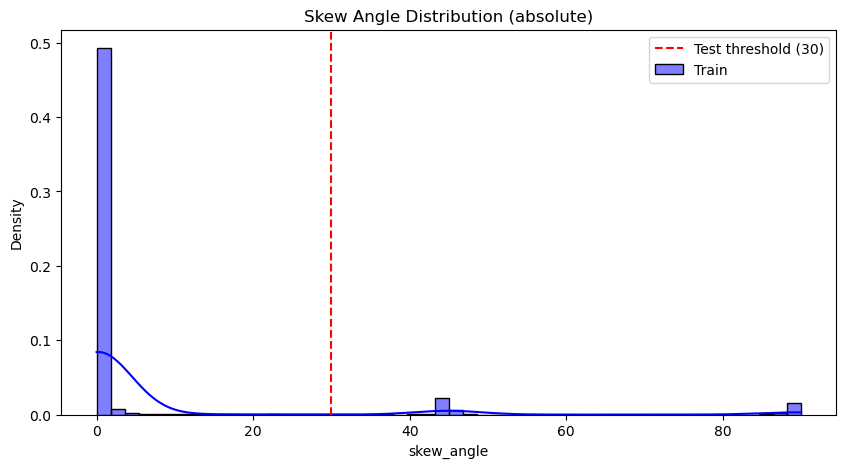

In [16]:
# Skew Angle Î∂ÑÌè¨ ÎπÑÍµê

plt.figure(figsize=(10, 5))
sns.histplot(abs(train_eda_df["skew_angle"]), color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_skew_thresh, color="red", linestyle="--", label=f"Test threshold ({test_skew_thresh})")
plt.title("Skew Angle Distribution (absolute)")
plt.legend()
plt.show()

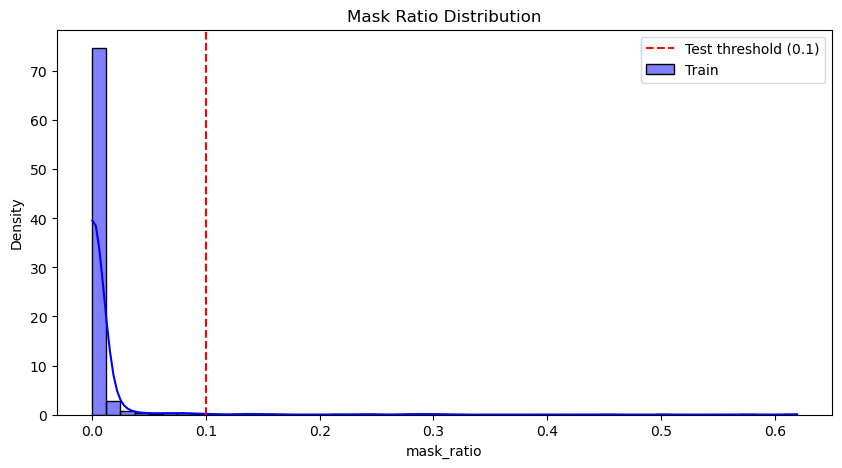

In [17]:
# Mask Ratio Î∂ÑÌè¨ ÎπÑÍµê

plt.figure(figsize=(10, 5))
sns.histplot(train_eda_df["mask_ratio"], color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_mask_thresh, color="red", linestyle="--", label=f"Test threshold ({test_mask_thresh})")
plt.title("Mask Ratio Distribution")
plt.legend()
plt.show()

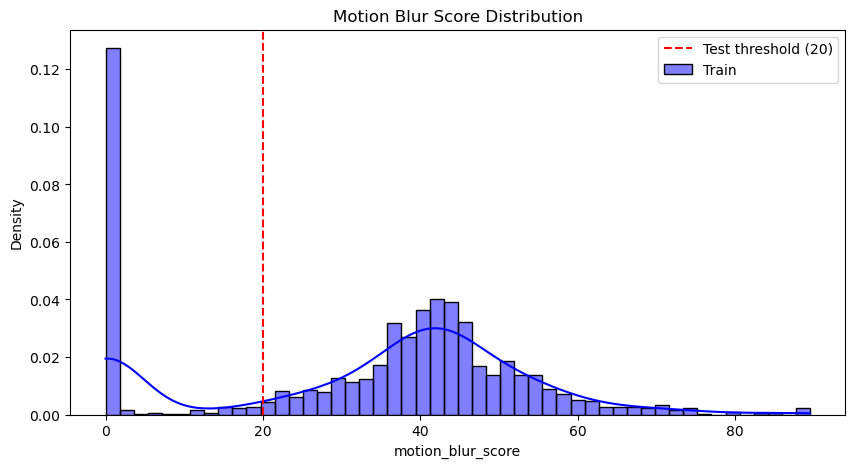

In [19]:
# Motion Blur Score Î∂ÑÌè¨ ÎπÑÍµê

plt.figure(figsize=(10, 5))
sns.histplot(train_eda_df["motion_blur_score"], color="blue", label="Train", bins=50, stat="density", kde=True)
plt.axvline(test_motion_blur_thresh, color="red", linestyle="--", label=f"Test threshold ({test_motion_blur_thresh})")
plt.title("Motion Blur Score Distribution")
plt.legend()
plt.show()

In [18]:
# üí° Í∞Å Ìï≠Î™©Î≥Ñ augmentation ÏÑ§Í≥Ñ ÌûåÌä∏ Ï∂úÎ†•

print("‚úÖ Ï¶ùÍ∞ï ÏÑ§Í≥Ñ Ï†úÏïà")

# Blur
blur_ratio = (train_eda_df["blur_score"] < test_blur_thresh).mean()
print(f"Blur ÎπÑÏú® (Train): {blur_ratio:.2%} ‚Üí Test ÎπÑÏú®Ïóê ÎßûÍ≤å blur augmentation ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§")

# Noise
noise_ratio = (train_eda_df["noise_score"] > test_noise_thresh).mean()
print(f"Noise-heavy ÎπÑÏú® (Train): {noise_ratio:.2%} ‚Üí Noise injection Ï∂îÍ∞Ä ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§")

# Skew
skew_ratio = (abs(train_eda_df["skew_angle"]) > test_skew_thresh).mean()
print(f"ÌÅ∞ Skew Angle ÎπÑÏú® (Train): {skew_ratio:.2%} ‚Üí Random rotation augmentation ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§")

# Mask
mask_ratio = (train_eda_df["mask_ratio"] > test_mask_thresh).mean()
print(f"Mask-heavy ÎπÑÏú® (Train): {mask_ratio:.2%} ‚Üí Cutout, Random erasing Îì± ÎßàÏä§ÌÇπ augmentation ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§")

# Motion Blur
motion_blur_ratio = (train_eda_df["motion_blur_score"] < test_motion_blur_thresh).mean()
print(f"Í∞ïÌïú Motion blur ÎπÑÏú® (Train): {motion_blur_ratio:.2%} ‚Üí Motion blur augmentation ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§")

‚úÖ Ï¶ùÍ∞ï ÏÑ§Í≥Ñ Ï†úÏïà
Blur ÎπÑÏú® (Train): 11.46% ‚Üí Test ÎπÑÏú®Ïóê ÎßûÍ≤å blur augmentation ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§
Noise-heavy ÎπÑÏú® (Train): 1.91% ‚Üí Noise injection Ï∂îÍ∞Ä ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§
ÌÅ∞ Skew Angle ÎπÑÏú® (Train): 8.85% ‚Üí Random rotation augmentation ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§
Mask-heavy ÎπÑÏú® (Train): 1.46% ‚Üí Cutout, Random erasing Îì± ÎßàÏä§ÌÇπ augmentation ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§
Í∞ïÌïú Motion blur ÎπÑÏú® (Train): 25.03% ‚Üí Motion blur augmentation ÌïÑÏöî Ïó¨Î∂Ä Í≥†Î†§
